# Work with multiple injections

In this tutorial we will process the dataset containing the results of serial injections. The main difference from the previous tutorial is that in this case single cell can have multiple barcodes and be part of two different clones.

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sclitr as sl

sc.set_figure_params(dpi=80)
sns.set_style("ticks")

Let's download the dataset from Erickson, Isaev et al. paper.

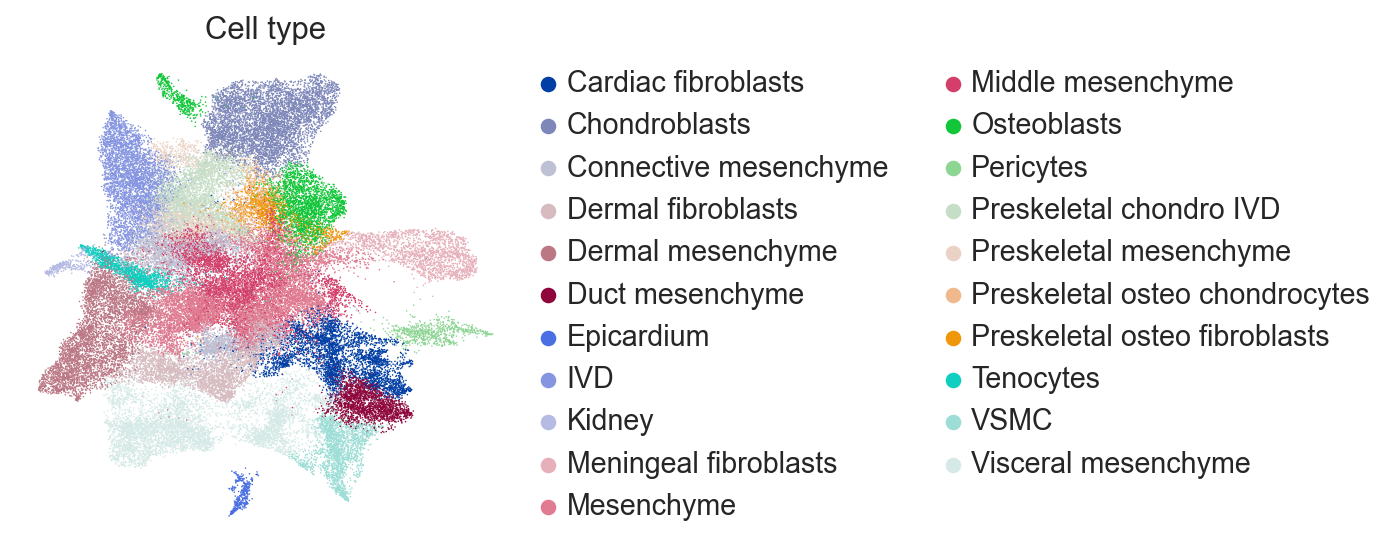

In [4]:
adata = sl.datasets.Erickson_murine_development(subset="mesenchyme")

sc.pl.umap(adata, color="celltype_l2", frameon=False, title="Cell type")

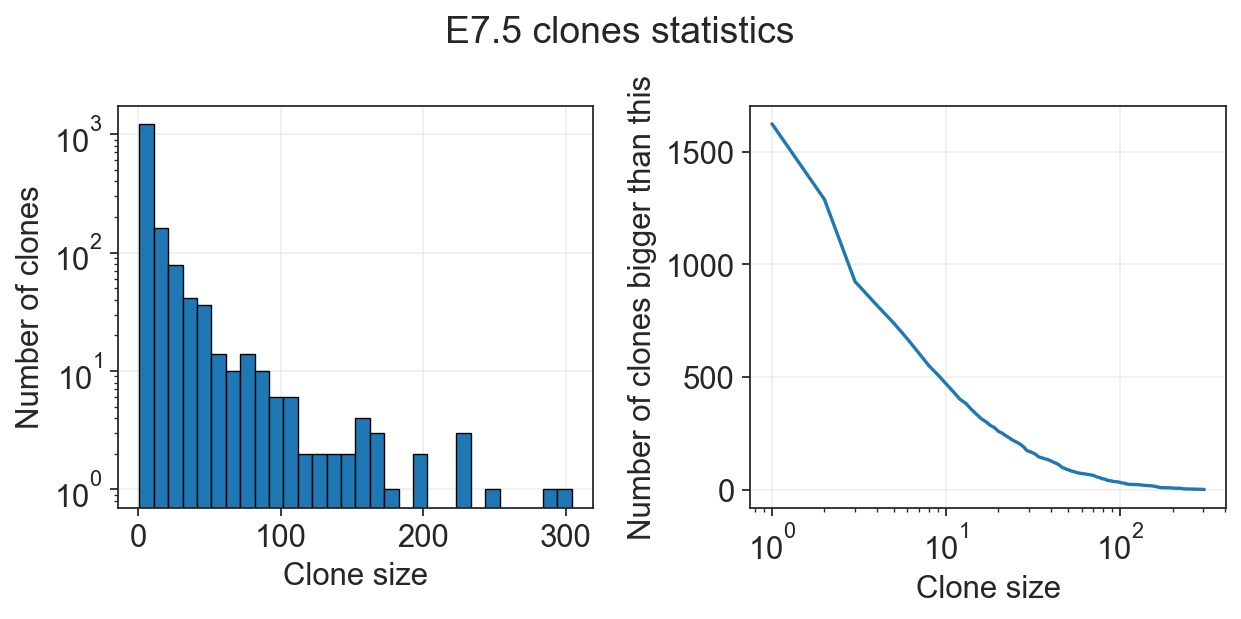

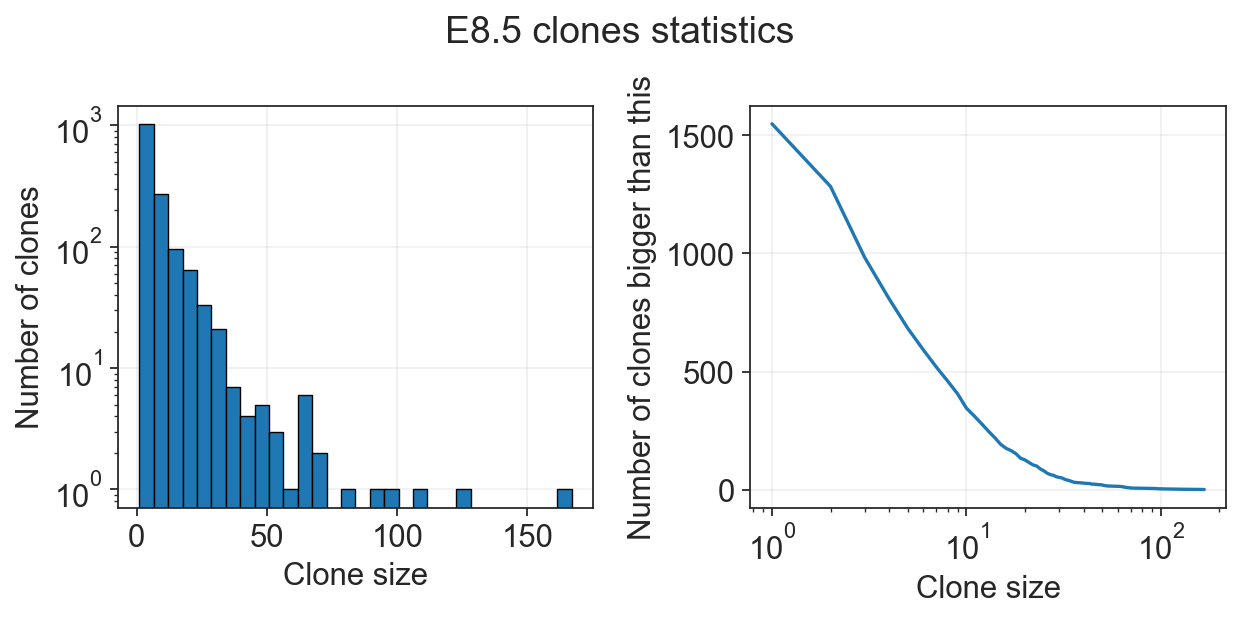

In [5]:
sl.pl.basic_stats(adata, obs_name="E7.5:clones", title="E7.5 clones statistics")
sl.pl.basic_stats(adata, obs_name="E8.5:clones", title="E8.5 clones statistics")

We can check consistency between double these two injections. In the perfect situation, all of the clones from late injection should eaither not contain early barcodes at all or be a part of the bigger early clone. But in reality, unfortunately, we have lot's of false negative and false positive cells within clones, so we can vizually inspect amount of noise in the data.

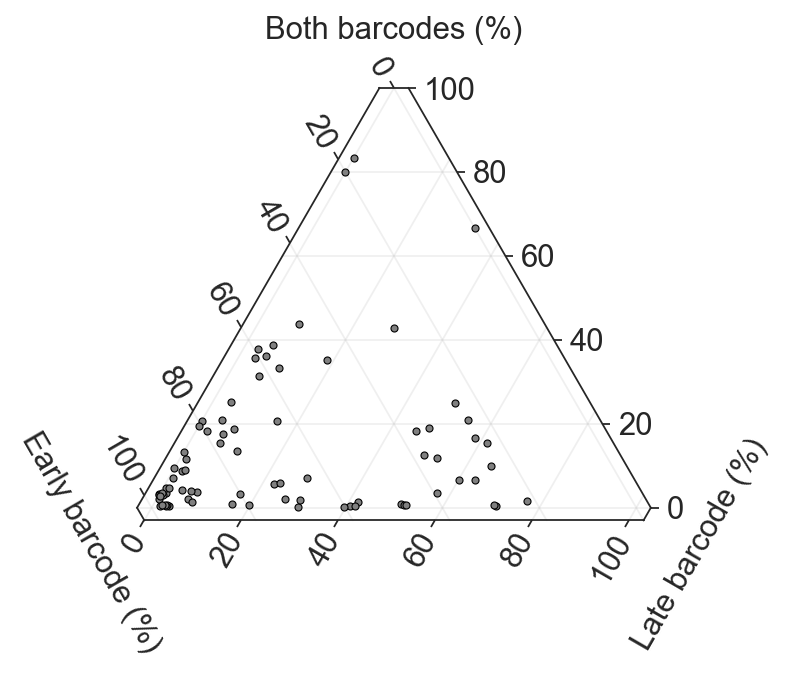

In [6]:
# Right now it works only with double injections

sl.pl.double_injection_composition(
    adata,
    early_injection="E7.5:clones",
    late_injection="E8.5:clones",
)

## Embedding preparation

Firstly, we're going to create an object with deduplicated cells with two barcodes. Simply speaking, if a single cell is a part of two different clones, it will be used twice during the training of the clone2vec (as part of the first and the second clones).

In [7]:
adata_demult = sl.pp.prepare_multiple_injections(
    adata,
    injection_cols=["E7.5:clones", "E8.5:clones"],
)

/home/sergey/tools/scLiTr/sclitr/pp.py:148: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_demult.obs[final_obs_name] = clone_obs
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Now we can work with this object in a standard way.

In [8]:
sl.tl.clonal_nn(
    adata_demult,
    obs_name="clone",
    use_rep="X_pca_harmony",
    min_size=5,
    tqdm_bar=True,
)

100%|██████████| 62778/62778 [01:00<00:00, 1030.49it/s]


In [9]:
clones = sl.tl.clone2vec(
    adata_demult,
    obs_name="clone",
    fill_ct="celltype_l2",
    device="cuda:0",
    n_epochs=50,
)

100%|██████████| 50/50 [08:25<00:00, 10.11s/it]
/home/sergey/tools/scLiTr/sclitr/tl.py:616: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_counts = adata_only_clones.obs.groupby(


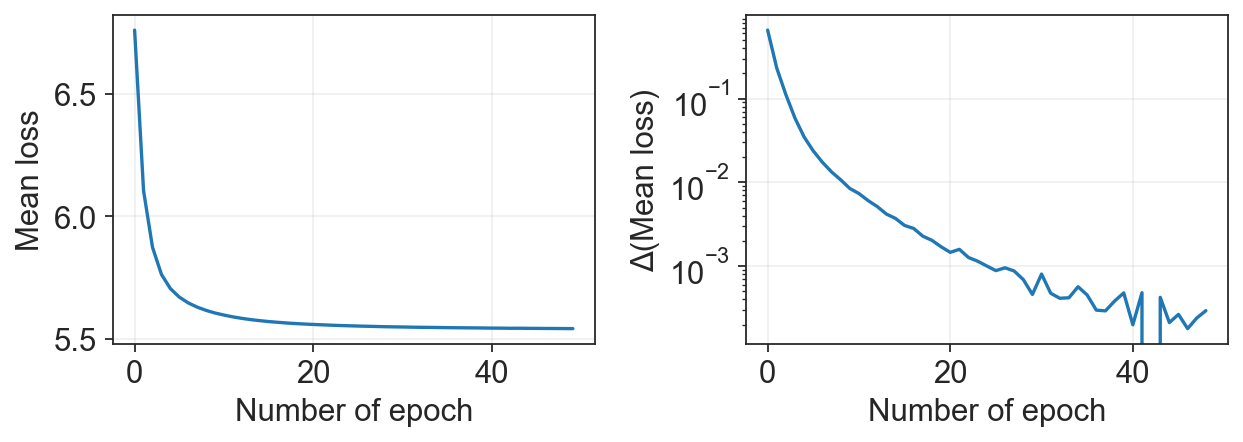

In [4]:
sl.pl.epochs_loss(clones)

In [11]:
sc.pp.neighbors(clones, use_rep="clone2vec", n_neighbors=15)
sc.tl.umap(clones)

2025-05-02 14:16:45.731563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-02 14:16:45.750718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-02 14:16:45.756531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-02 14:16:45.770472: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-02 14:16:46.517782: W tensorflow/compiler/tf2

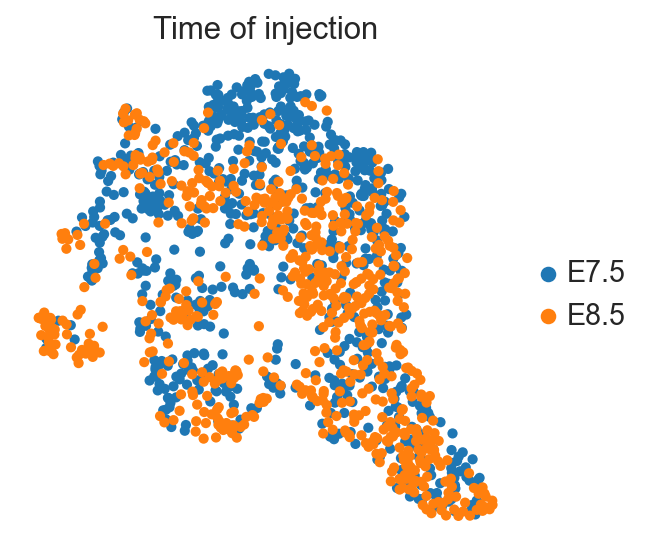

In [5]:
clones.obs["timepoint"] = [i.split(":")[0] for i in clones.obs_names]

sc.pl.umap(clones, color="timepoint", frameon=False, title="Time of injection")

## Clonal clustering

Here we can continue processing in a way similar to the first tutorial.

/tmp/ipykernel_20239/3702231428.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(clones, resolution=1)


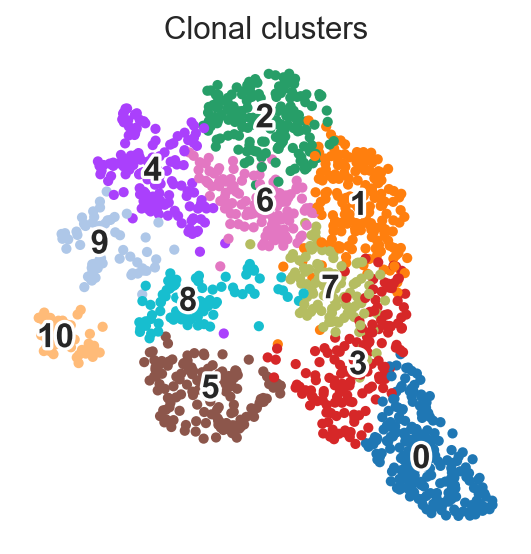

In [7]:
sc.tl.leiden(clones, resolution=1)

sc.pl.umap(
    clones,
    color="leiden",
    frameon=False,
    title="Clonal clusters",
    legend_loc="on data",
    legend_fontsize=15,
    legend_fontoutline=3
)

In [8]:
sl.tl.transfer_clonal_annotation(
    adata_demult,
    clones,
    adata_clone_name="clone",
    adata_obs_name="Clonal cluster",
    clones_obs_name="leiden",
    fill_values="NA",
)

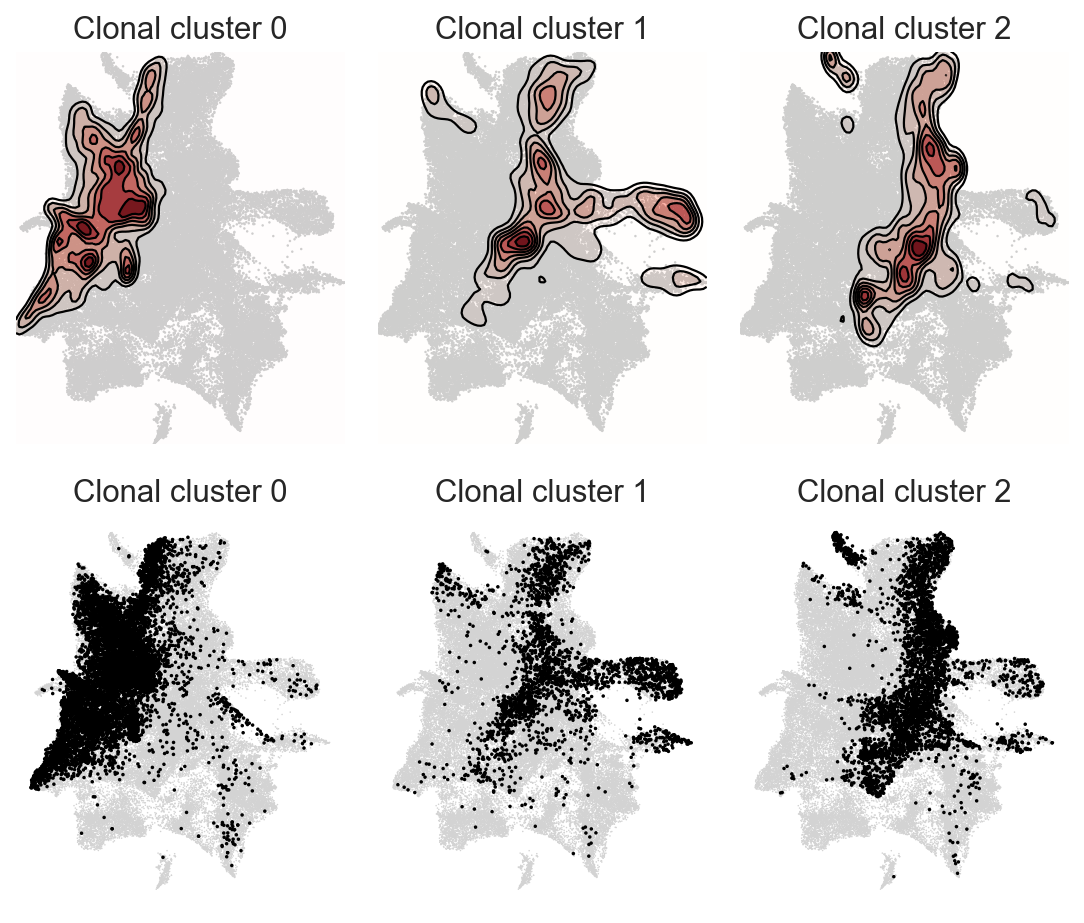

In [9]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(7, 6))

for i, clonal_cluster in enumerate(["0", "1", "2"]):
    sl.pl.kde(
        adata_demult,
        groupby="Clonal cluster",
        group=clonal_cluster,
        title=f"Clonal cluster {clonal_cluster}",
        ax=axes[0, i],
    )

    sl.pl.clone(
        adata_demult,
        clone_col="Clonal cluster",
        clone_name=clonal_cluster,
        title=f"Clonal cluster {clonal_cluster}",
        s=10,
        ax=axes[1, i],
    )
    
fig.tight_layout()

In [ ]:
clones.write_h5ad("clones_trunk_mes.h5ad")
adata_demult.write_h5ad("adata_trunk_mes.h5ad")